<a href="https://colab.research.google.com/github/sauragr/datasciencecoursera/blob/master/Resnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_name = 'cifar10-resnet'

In [3]:
#Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,'.')

#Extract from Archive
with tarfile.open('./cifar10.tgz' , 'r:gz') as tar:
  tar.extractall(path='./data')

#Look into Data Directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

100%|██████████| 135M/135M [00:04<00:00, 31.8MB/s]


['train', 'test']
['horse', 'deer', 'dog', 'frog', 'ship', 'truck', 'cat', 'bird', 'automobile', 'airplane']


In [4]:
#Data Transforms(normalization and data augmentation)
stats = ((0.4914 , 0.4822 , 0.4465) , (0.2023 , 0.1994 , 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        #tt.RandomRotate(),
                        #tt.RandomResizedCrop(256,scale=(0.5,0.8),ratio=(1,1)),
                        #tt.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1),
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor() , tt.Normalize(*stats)])


In [5]:
#Pytorch Datasets
train_ds = ImageFolder(data_dir + '/train' , train_tfms)
valid_ds = ImageFolder(data_dir + '/test' , valid_tfms)


In [6]:
batch_size = 400

In [7]:
#pytorch data loaders
train_dl = DataLoader(train_ds , batch_size , shuffle=True,num_workers=3,pin_memory=True)
valid_dl = DataLoader(valid_ds,batch_size*2,num_workers=3,pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
def denormalize(images,means,stds):
  means = torch.tensor(means).reshape(1,3,1,1)#(batch_size,channel,height,width)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images * stds + means

def show_batch(dl):
  for images , labels in dl:
      fig , ax = plt.subplots(figsize=(12,12))
      ax.set_xticks([]) ; ax.set_yticks([])
      denorm_images = denormalize(images , *stats)
      ax.imshow(make_grid(denorm_images[:64] , nrow=8).permute(1,2,0).clamp(0,1))
      break

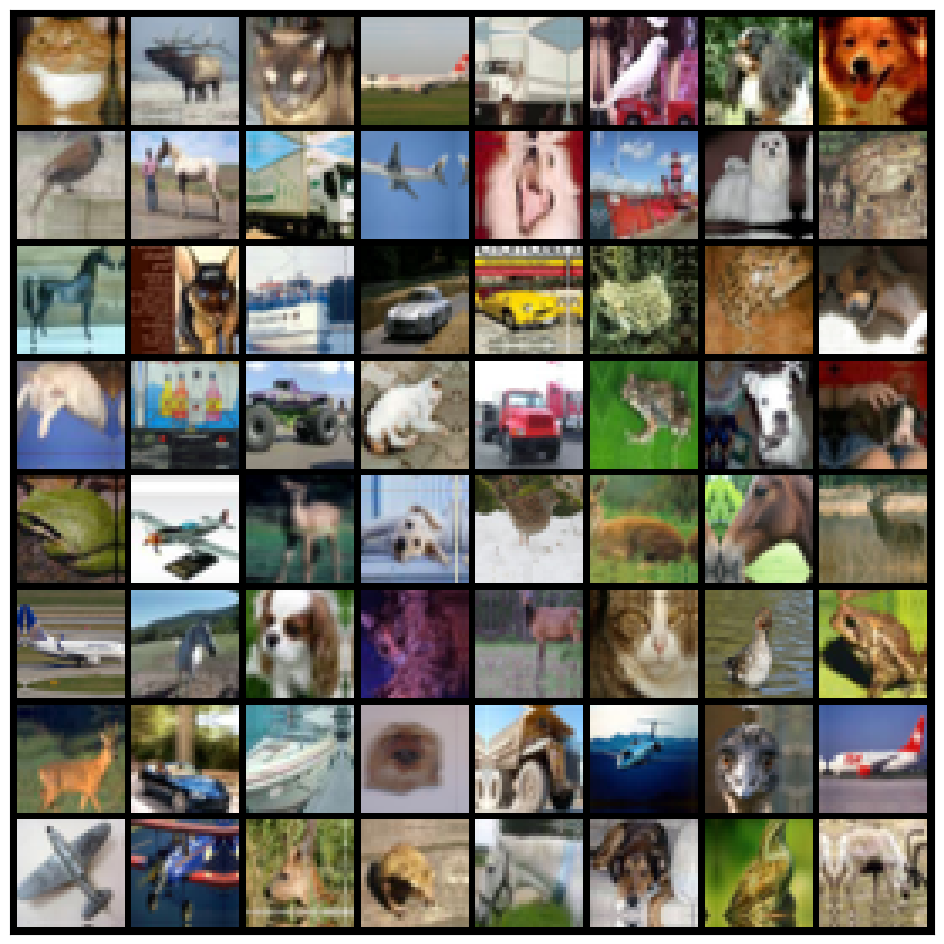

In [9]:
show_batch(train_dl)

In [10]:
#Using a GPU
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data , device):
  if isinstance(data, (list,tuple)):
    return[to_device(x,device) for x in data]
  return data.to(device,non_blocking = True)

class DeviceDataLoader():
  def __init__(self , dl , device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl , device)
valid_dl = DeviceDataLoader(valid_dl , device)

In [14]:
#Example of Residual Block
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3,out_channels =3,kernel_size=3,stride=1,padding=1)
    self.relu1 = nn.Relu()
    self.conv2 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu2 = nn.Relu()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out) + x